# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

In [2]:
import matplotlib.pyplot as plt
from statistics import NormalDist
import math

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [3]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=imprint', 'case/server=malicious-model'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda:2') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=torch.float)
setup

Investigating use case single_imagenet with server type malicious_model.
Attack settings are:
type: analytic
attack_type: imprint-readout



{'device': device(type='cuda', index=2), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [4]:
cfg.case.user.data_idx = 200
cfg.case.user.data_with_labels = 'unique'

cfg.case.user.num_data_points = 64
cfg.case.server.model_modification.type = 'ImprintBlock' 
cfg.case.server.model_modification.num_bins = 128
cfg.case.server.model_modification.position = None  #3.0.conv?
cfg.case.server.model_modification.connection = 'add'


cfg.case.server.model_modification.linfunc = 'fourier'
cfg.case.server.model_modification.mode = 32

cfg.case.server.model_gain = 1
cfg.case.server.model_modification.gain = 1

cfg.case.server.has_external_data = False

### Instantiate all parties

In [5]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Model architecture <class 'torch.nn.modules.container.Sequential'> loaded with 44,824,744 parameters and 53,173 buffers.
Overall this is a data ratio of       5:1 for target shape [64, 3, 224, 224] given that num_queries=1.


In [6]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of data points: 64
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: Sequential
            loss function: CrossEntropyLoss()

            Data:
            Dataset: ImageNet
            data_idx: 200
        


### Simulate an attacked FL protocol

True user data is returned only for analysis

In [7]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

In [8]:
#grads = shared_data['gradients'][0]
#[(g.norm(), g.mean(), g.std()) for g in grads]

In [9]:
#torch.norm(torch.stack([torch.norm(g, 2) for g in grads]), 2)

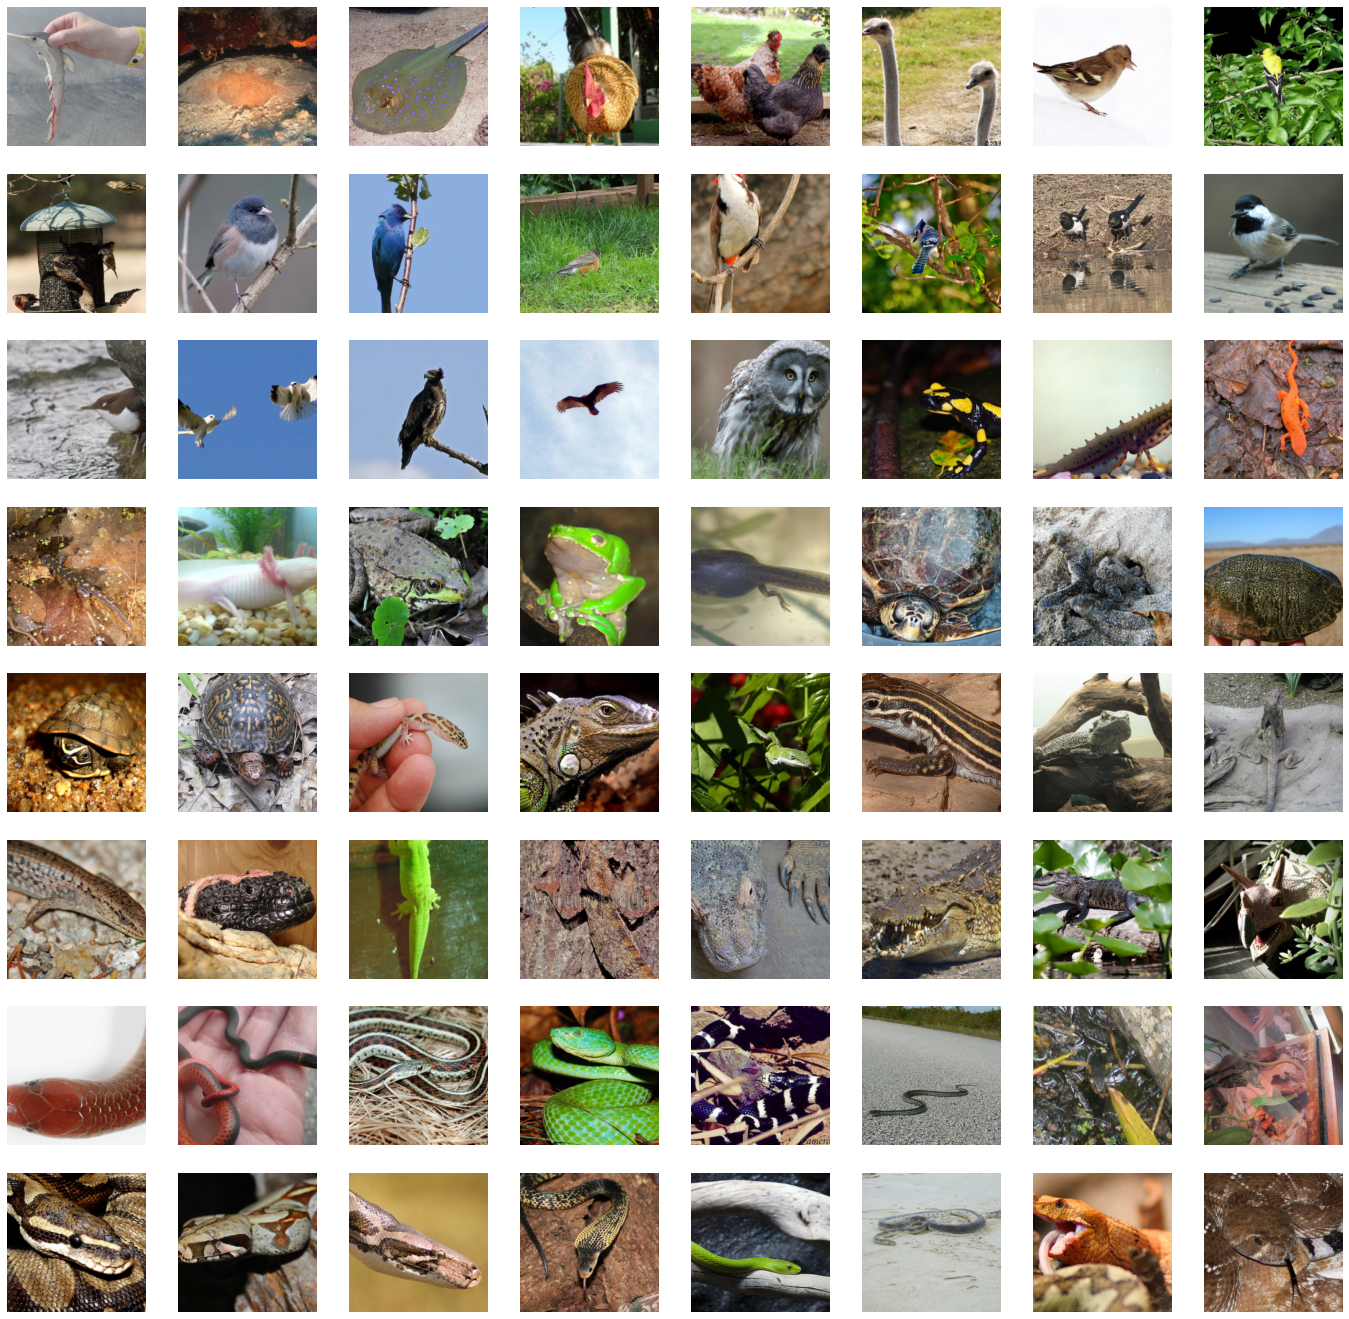

In [10]:
user.plot(true_user_data)

# Reconstruct user data

In [11]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

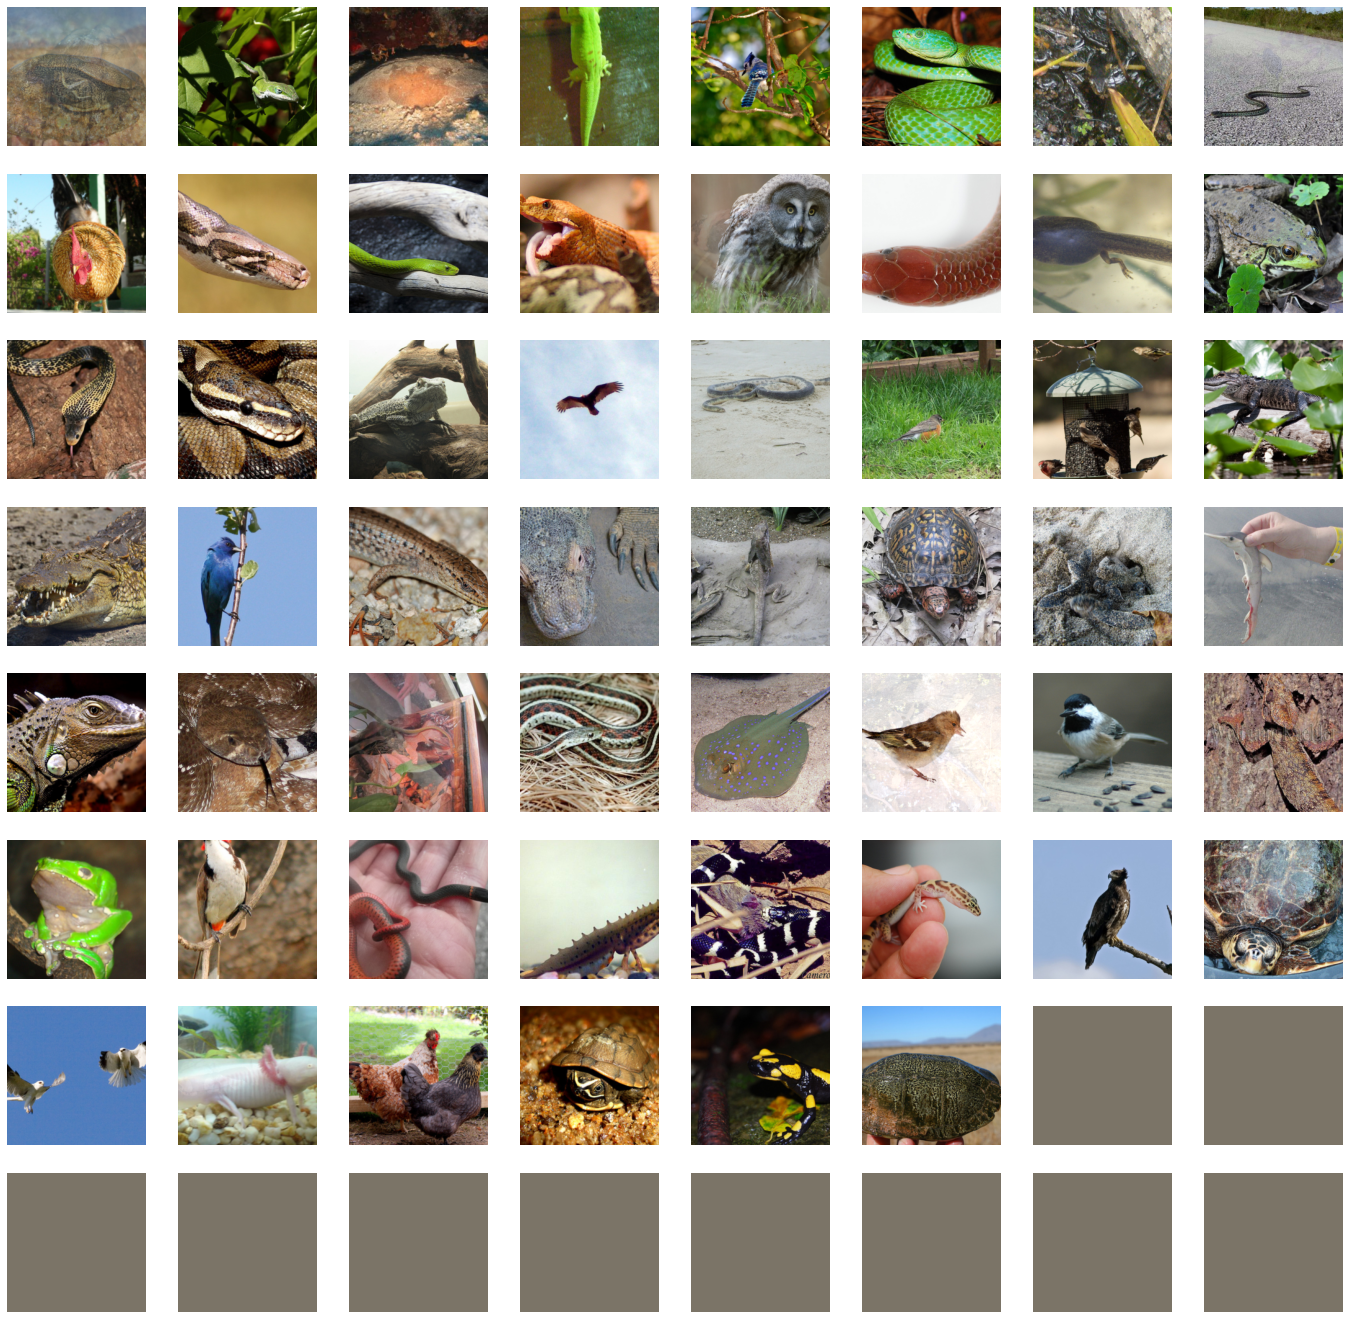

In [12]:
user.plot(reconstructed_user_data, scale=False)

In [13]:
# How good is the reconstruction?
# metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
#                                     server_payload, server.model, user.dataloader, setup=setup,
#                                     order_batch=True, compute_full_iip=False, skip_rpsnr=True)

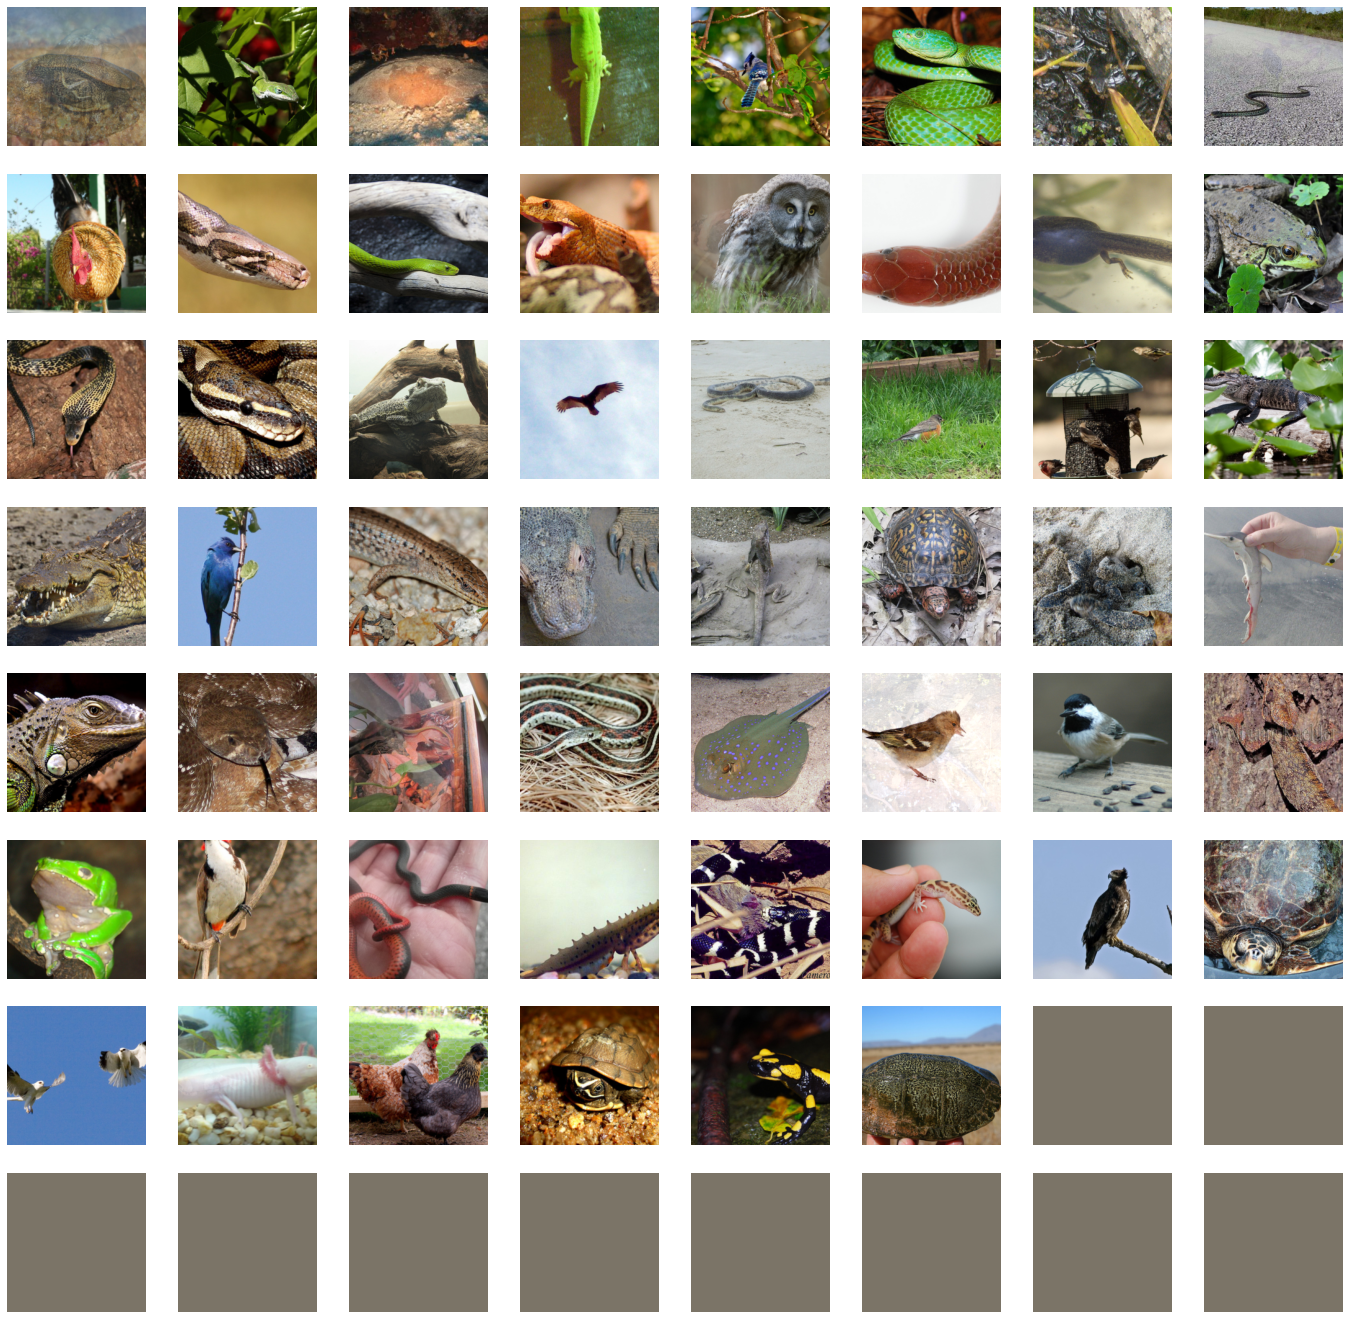

In [14]:
user.plot(reconstructed_user_data, scale=False)

# Analyze distribution on ground truth data

This is not possible in general, but helpful as a sanity check

In [15]:
block_lin = user.model[1].linear0.weight[0].clone().detach()
print(torch.std_mean(block_lin))
# std, mu = torch.std_mean(block_lin)
# block_lin = (block_lin - mu) / (std + 1e-6)

(tensor(0.0006, device='cuda:2'), tensor(2.1642e-11, device='cuda:2'))


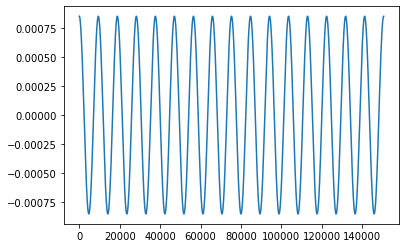

In [16]:
plt.plot(block_lin.detach().cpu().numpy())

In [17]:
vals = torch.zeros(len(user.dataloader.dataset))
counter = 0
with torch.inference_mode():
    for image, _ in iter(user.dataloader):
        image = image.to(**setup)
        B = image.shape[0]
        vals[counter:counter+B] = (block_lin[None, :] * image.flatten(start_dim=1)).sum(dim=1).detach().cpu()
        counter += B

In [18]:
# vals = vals * torch.tensor(block_lin.shape[0])

In [19]:
from scipy.stats import laplace

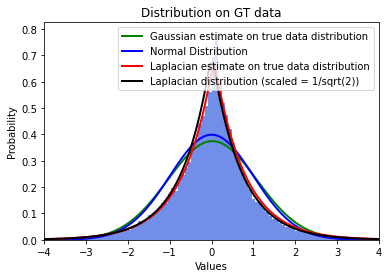

In [23]:
std_data, mu_data = torch.std_mean(vals)

# the histogram of the data
n, bins, patches = plt.hist(vals.numpy(), 250, density=True, facecolor='royalblue', alpha=0.75)


plt.xlabel('Values')
plt.ylabel('Probability')
plt.xlim(-4, 4)
plt.title('Distribution on GT data')

xmin, xmax = plt.xlim()
x = torch.linspace(xmin, xmax, 100)
# p = [NormalDist(mu, std).pdf(xx) for xx in x]
# plt.plot(x, p, 'k', linewidth=2)

p = [NormalDist(mu_data, std_data).pdf(xx) for xx in x]
plt.plot(x, p, 'g', linewidth=2, label='Gaussian estimate on true data distribution')

p = [NormalDist(0, 1).pdf(xx) for xx in x]
plt.plot(x, p, 'b', linewidth=2, label='Normal Distribution')

loc, scale = laplace.fit(vals.numpy())
p = laplace.pdf(x, loc, scale)
plt.plot(x, p, 'r', linewidth=2, label='Laplacian estimate on true data distribution')

p = laplace.pdf(x, 0, 1/math.sqrt(2))
plt.plot(x, p, 'k', linewidth=2, label='Laplacian distribution (scaled = 1/sqrt(2))')

plt.legend()
plt.show()

In [24]:
mu_data, std_data

(tensor(0.0169), tensor(1.0652))

In [25]:
loc, scale

(0.055307742, 0.726941328125)